In [2]:
%load_ext autoreload
%autoreload 2
import sys
import glob
import os
sys.path.append("pconv")
sys.path.append("MonarchCircuits")
import pyjuice
from src.dataset import ImageNet
from src.utils import patchify
import matplotlib.pyplot as plt
import torch
from src.colours import Rgb2YccLossy, Rgb2GenT
import numpy as np
import pandas as pd
from pc_mini_em.src.transforms.color_trans import RGB2YCoCgR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%env CUDA_LAUNCH_BLOCKING=1
!echo $CUDA_LAUNCH_BLOCKING

env: CUDA_LAUNCH_BLOCKING=1
1


In [75]:
results=[]

for ckpt in os.listdir("MonarchCircuits/checkpoints"):
    name_element = ckpt.removesuffix(".jpc").split("_")  

    if len(name_element)==4:
        resolution, patch, color_transform, layer =name_element
    else:
        resolution, patch, color_transform =name_element
        layer="monarch"

    # if color_transform=="lossy":
    #     continue
    patch = int(patch.split("x")[0])  
    resolution=int(resolution)
    print(f"loading PC: {resolution}, {patch}, {color_transform}, {layer}")
    pc = pyjuice.load(os.path.join("MonarchCircuits/checkpoints", ckpt))
    pc = pyjuice.compile(pc, device=0,     force_gpu_compilation=True,).to(torch.device("cuda:0"))
    print(pc.device)
    transform=None
    if color_transform=="lossy":
        transform=Rgb2YccLossy()
    elif color_transform=="lossless":
        transform=RGB2YCoCgR(rgb_range=(0,255))

    print("Setting up dataset")
    dataset = ImageNet("pconv/datasets", resolution=resolution, colour_transform=transform)
    dataset.setup("")
    test_dl = dataset.test_dataloader()
    patch_fn = patchify((patch,patch),(patch,patch), compile=False)

    lls=[]
    with torch.no_grad():
        print("Start testing")
        for batch in test_dl:
            batch=batch.cuda(0)
            patched = patch_fn(batch)
            patched = patched.reshape(-1, patch*patch*3)
            ll = pc(patched)
            ll = ll.cpu().sum()
            lls.append(ll)
        lls_mean = torch.tensor(lls).sum().item()/len(test_dl.dataset)
        bpd = lls_mean/(np.log(2)*3*resolution*resolution)
    pc.cpu()
    del pc            # delete Python references
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    results.append({
        "layer":layer,
        "resolution":resolution,
        "patch":patch,
        "color_transform":color_transform,
        "bpd":bpd,
        "test_ll":lls_mean
    })
results_df= pd.DataFrame(results)

loading PC: 64, 2, lossy, monarch
Compiling 11 TensorCircuit layers...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 120.21it/s]


cuda:0
Setting up dataset
torch.Size([3, 64, 64])
torch.int64
Start testing
loading PC: 32, 16, lossy, monarch
Compiling 164 TensorCircuit layers...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [01:57<00:00,  1.40it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 32, 1, lossy, monarch
Compiling 2 TensorCircuit layers...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 117.67it/s]

cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing


loading PC: 32, 4, lossy, monarch
Compiling 32 TensorCircuit layers...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.04it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 32, 32, lossless, monarch
Compiling 491 TensorCircuit layers...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 491/491 [05:14<00:00,  1.56it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 32, 8, lossy, dense
Compiling 30 TensorCircuit layers...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 32, 2, lossy, dense
Compiling 6 TensorCircuit layers...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 64, 1, lossy, monarch
Compiling 2 TensorCircuit layers...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 105.84it/s]

cuda:0
Setting up dataset


torch.Size([3, 64, 64])
torch.int64
Start testing
loading PC: 32, 1, lossless, monarch
Compiling 2 TensorCircuit layers...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 143.02it/s]

cuda:0
Setting up dataset


torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 32, 32, lossy, monarch
Compiling 479 TensorCircuit layers...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 479/479 [04:36<00:00,  1.73it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 32, 16, lossless, monarch
Compiling 167 TensorCircuit layers...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:34<00:00,  4.84it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 32, 1, lossy, dense
Compiling 2 TensorCircuit layers...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 180.64it/s]

cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing


loading PC: 32, 8, lossless, monarch
Compiling 62 TensorCircuit layers...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:06<00:00,  9.82it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 32, 8, lossy, monarch
Compiling 83 TensorCircuit layers...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:06<00:00, 13.30it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 32, 4, lossless, monarch
Compiling 29 TensorCircuit layers...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 62.73it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 32, 2, lossless, monarch
Compiling 11 TensorCircuit layers...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 126.71it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 32, 16, lossy, dense
Compiling 54 TensorCircuit layers...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:03<00:00, 17.79it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 32, 4, lossy, dense
Compiling 10 TensorCircuit layers...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 60.18it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 32, 2, lossy, monarch
Compiling 11 TensorCircuit layers...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 104.16it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing
loading PC: 32, 32, lossy, dense
Compiling 161 TensorCircuit layers...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [01:05<00:00,  2.44it/s]


cuda:0
Setting up dataset
torch.Size([3, 32, 32])
torch.int64
Start testing


In [76]:
res_df = pd.DataFrame(results)
res_df["bpd"]=res_df["bpd"].abs()

In [41]:
res_df_our_lossless = pd.DataFrame(results)


In [57]:
res_df_our_lossless["bpd"]=res_df_our_lossless["bpd"].abs()

In [63]:
res_df = pd.concat([res_df, res_df_our_lossless])

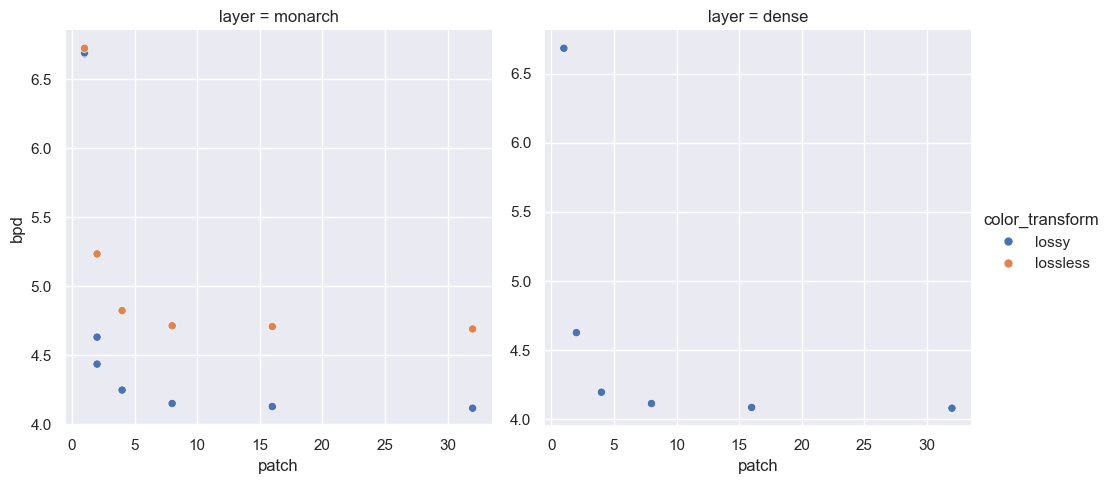

In [77]:
import seaborn as sb
import matplotlib.pyplot as plt
sb.set_theme()
sb.relplot(res_df, x="patch", y="bpd", hue="color_transform", col="layer", facet_kws={"sharey":False})
# plt.xscale("log")

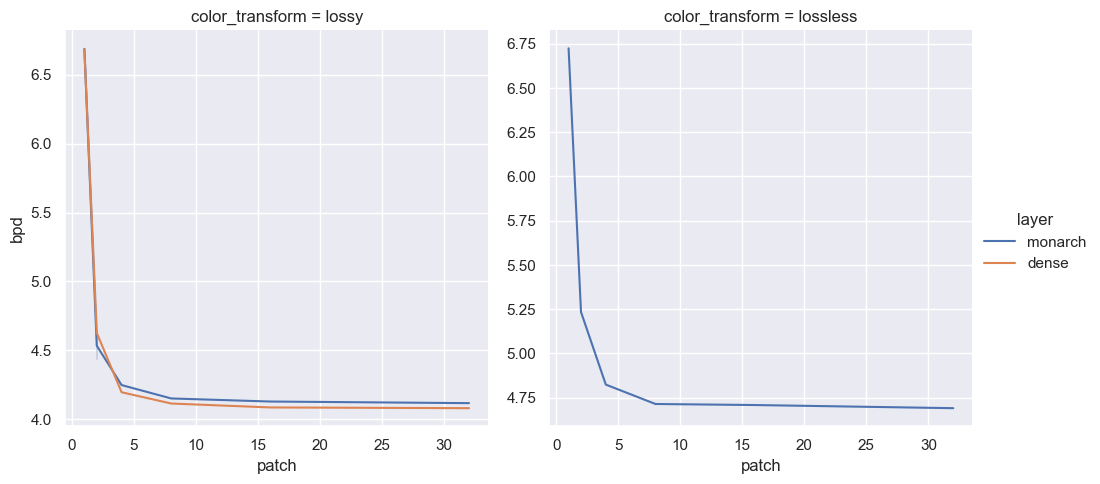

In [78]:
sb.relplot(res_df, x="patch", y="bpd", hue="layer", col="color_transform", facet_kws={"sharey":False}, kind="line")


In [6]:
patch_fn = patchify((8,8),(8,8), compile=False)
batch.cuda(0)

tensor([[[[ 85, 100, 103,  ...,  99, 100, 100],
          [ 79,  98, 103,  ...,  99, 100, 101],
          [ 68,  89,  98,  ..., 101, 102, 103],
          ...,
          [ 43,  45,  45,  ...,  46,  48,  48],
          [ 41,  40,  42,  ...,  40,  39,  37],
          [ 37,  35,  35,  ...,  39,  38,  39]],

         [[152, 154, 154,  ..., 141, 140, 139],
          [150, 152, 152,  ..., 143, 142, 142],
          [146, 150, 151,  ..., 146, 146, 146],
          ...,
          [145, 146, 146,  ..., 141, 142, 141],
          [144, 143, 144,  ..., 138, 138, 137],
          [129, 134, 138,  ..., 137, 137, 137]],

         [[130, 129, 129,  ..., 130, 129, 130],
          [130, 129, 130,  ..., 130, 130, 129],
          [130, 130, 129,  ..., 130, 130, 131],
          ...,
          [129, 129, 129,  ..., 130, 130, 130],
          [129, 128, 129,  ..., 129, 129, 129],
          [129, 128, 128,  ..., 129, 129, 129]]],


        [[[ 81,  98,  97,  ..., 115, 112, 105],
          [ 79, 101, 102,  ..., 112

In [7]:
patched = patch_fn(batch)

In [10]:
pc = pyjuice.load(os.path.join("MonarchCircuits/checkpoints", "32_8x8_lossy.jpc"))
pc = pyjuice.compile(pc, device=0,     force_gpu_compilation=True,).to(torch.device("cuda:0"))

Compiling 83 TensorCircuit layers...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:06<00:00, 12.28it/s]


In [11]:
patched.shape

torch.Size([512, 3, 8, 8])

In [12]:
pc

TensorCircuit(
  (input_layer_group): LayerGroup(
    (layer_0): InputLayer()
  )
  (prod_layer_0): LayerGroup(
    (layer_0): ProdLayer(
      (partitioned_nids): FastParamList(  (0): Parameter containing: [torch.int64 of size 1056 (cuda:0)])
      (partitioned_cids): FastParamList(  (0): Parameter containing: [torch.int64 of size 1056x4 (cuda:0)])
      (partitioned_u_cids): FastParamList(  (0): Parameter containing: [torch.int64 of size 2144 (cuda:0)])
      (partitioned_parids): FastParamList(  (0): Parameter containing: [torch.int64 of size 2144x1 (cuda:0)])
    )
  )
  (sum_layer_0): LayerGroup(
    (layer_0): SumLayer(
      (partitioned_nids): FastParamList(  (0): Parameter containing: [torch.int64 of size 1056 (cuda:0)])
      (partitioned_cids): FastParamList(  (0): Parameter containing: [torch.int64 of size 1056x32 (cuda:0)])
      (partitioned_pids): FastParamList(  (0): Parameter containing: [torch.int64 of size 1056x32 (cuda:0)])
      (partitioned_pfids): FastParamList( 

In [14]:
pc(patched.reshape(-1,3*8*8))

tensor([[-455.7753],
        [-519.5325],
        [-643.6923],
        [-523.5497],
        [-430.5638],
        [-528.3755],
        [-532.0760],
        [-537.9231],
        [-432.6145],
        [-492.7831],
        [-436.2432],
        [-522.2863],
        [-385.9210],
        [-415.0716],
        [-406.9938],
        [-491.1953],
        [-589.0017],
        [-601.5024],
        [-457.1642],
        [-428.9697],
        [-660.0331],
        [-656.2717],
        [-455.0172],
        [-448.8711],
        [-503.3603],
        [-581.9732],
        [-457.6241],
        [-496.6332],
        [-476.2863],
        [-488.8589],
        [-450.0354],
        [-454.6284],
        [-558.7551],
        [-538.0196],
        [-578.7083],
        [-497.5547],
        [-612.2458],
        [-656.3290],
        [-585.6351],
        [-498.4104],
        [-600.5867],
        [-693.8568],
        [-726.3233],
        [-459.7951],
        [-520.4227],
        [-573.9579],
        [-658.1311],
        [-406

In [5]:
results=[]
for csv_file in glob.glob("MonarchCircuits/exp/*.csv"):
    resolution, patch, color_transform, layer =csv_file.split("/")[-1].split(".")[0].split("_")
    print(csv_file)
    print(f"loading PC: {resolution}, {patch}, {color_transform}, {layer}")
    res = pd.read_csv(csv_file)
    res["resolution"]=resolution
    res["patch"]=patch
    res["color_transform"]=color_transform
    res["layer"]=layer
    results.append(res)
res_df = pd.concat(results)

res_df

MonarchCircuits/exp/32_2x2_lossy_dense.csv
loading PC: 32, 2x2, lossy, dense
MonarchCircuits/exp/32_16x16_lossy_monarch.csv
loading PC: 32, 16x16, lossy, monarch
MonarchCircuits/exp/32_4x4_lossy_dense.csv
loading PC: 32, 4x4, lossy, dense
MonarchCircuits/exp/32_1x1_lossy_monarch.csv
loading PC: 32, 1x1, lossy, monarch
MonarchCircuits/exp/32_1x1_lossy_dense.csv
loading PC: 32, 1x1, lossy, dense
MonarchCircuits/exp/32_2x2_lossy_monarch.csv
loading PC: 32, 2x2, lossy, monarch


,Unnamed: 0,val_ll,train_mem_avg,train_step_time,val_mem_avg,val_step_time,resolution,patch,color_transform,layer
0,0,-38.510479,1.283205e+08,0.003399,8520192.0,0.001191,32,2x2,lossy,dense
0,0,-2201.924531,6.284755e+09,0.060272,8520192.0,0.021221,32,16x16,lossy,monarch
0,0,-140.177715,5.301135e+08,0.005550,8520192.0,0.001588,32,4x4,lossy,dense
0,0,-13.891792,1.904742e+07,0.001709,19047424.0,0.000653,32,1x1,lossy,monarch
0,0,-13.904436,1.251277e+07,0.001836,8520192.0,0.000659,32,1x1,lossy,dense
0,0,-38.596428,7.788800e+07,0.006450,8520192.0,0.001965,32,2x2,lossy,monarch


In [ ]:
sb.relplot(res_df, x="patch", y="train_step_time", hue="layer", facet_kws={"sharey":True}, kind="line")

NameError: name 'sb' is not defined